# Improvements
- Use batch normalization
- Use simple model

In [1]:
# Import libraries

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras import layers

import os
import tempfile
import heapq
import re
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import pandas as pd
import numpy as np

Using TensorFlow backend.


In [2]:
# WORD-level
MAX_NUM_WORDS     = 15000
EMBEDDING_DIM     = 100
MAX_SEQ_LENGTH    = 500
USE_GLOVE         = True
KERNEL_SIZES      = [2,3]
FEATURE_MAPS      = [200,200]

# GENERAL
DROPOUT_RATE      = 0.3
HIDDEN_UNITS      = 200
NB_CLASSES        = 7
TEST_RATIO        = 0.2
VAL_RATIO         = 0.3

# LEARNING
BATCH_SIZE        = 100
NB_EPOCHS         = 5

In [3]:
# Read data
df = pd.read_csv("processed_for_CNN.csv")
df[['roles','msgs']]

roles  \
0      0.0 0.0 0.0 1.0 0.0 0.0 1.0   
1      0.0 0.0 0.0 0.0 1.0 0.0 0.0   
2      1.0 0.0 0.0 0.0 1.0 0.0 0.0   
3      1.0 0.0 0.0 0.0 0.0 0.0 0.0   
4      0.0 0.0 1.0 0.0 0.0 0.0 0.0   
...                            ...   
71180  0.0 1.0 0.0 0.0 0.0 0.0 0.0   
71181  0.0 0.0 0.0 0.0 0.0 0.0 1.0   
71182  0.0 0.0 0.0 0.0 0.0 0.0 1.0   
71183  0.0 0.0 0.0 0.0 0.0 0.0 1.0   
71184  0.0 0.0 0.0 0.0 0.0 0.0 1.0   

                                                    msgs  
0      chinese wall training of one hour have be sche...  
1                                                he trip  
2      attach please find key contact list for energy...  
3      sue landwehr in government affair spoke to mem...  
4      thank you for signing up with ethink you may l...  
...                                                  ...  
71180  here be the sound system proposal reference oa...  
71181                             happy new year mark xl  
71182  feb dec trade feb dec ll go out at do not have...  
71183  bom to trade and feb trade away trade and feb ...  
71184  howdy bom go out at feb trade and mar away and...  

[71185 rows x 2 columns]

In [4]:
labels = list()
for line in df["roles"]:
    label= [int(float(i)) for i in line.split()]
    labels.append(label)
labels[:5]

[[0, 0, 0, 1, 0, 0, 1],
 [0, 0, 0, 0, 1, 0, 0],
 [1, 0, 0, 0, 1, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0]]

In [5]:
msgs = df["msgs"].to_list()
msgs[:5]

['chinese wall training of one hour have be schedule on the date list below the training be mandatory and allows ew to continue operating all it business include equity trading without violate the security la w please register for one of the four one hour session list below each session be tailor to particular commercial group and it would be preferable if you could attend the session for your group your particula group be the one highlight in bold on the list below monday march resource group monday march origination business development monday march financial trading group monday march head of trading desk each of the above session will be held at the downtown hyatt regency hotel in sandalwood room alternatively two make up session be schedul ed for tuesday march at and location informatio for the make up session will be announce later please confirm your attendance at one of these session with brenda whitehe ad by mail her at brenda whitehead enron com or call her at extension mark 

In [6]:
for i,x in enumerate(msgs):
    if type(x)!= str:
        msgs[i] = str(x)
        
X = msgs.copy()
y = labels.copy()

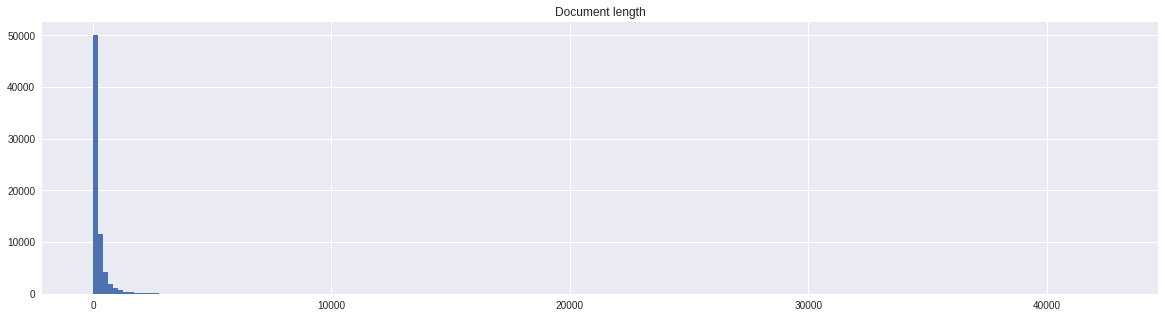

Text informations:
max length: 42549 / min length: 1 / mean length: 255 / limit length: 500


In [7]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index

result = [len(x.split()) for x in X]

# Plot histogram
plt.figure(figsize=(20,5))
plt.title('Document length')
plt.hist(result, 200, density=False, range=(0,np.max(result)))
plt.show()


print('Text informations:')
print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result), np.min(result),
                                                                                np.mean(result), MAX_SEQ_LENGTH))

# Padding all sequences to same length of `MAX_SEQ_LENGTH`
word_data = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

In [15]:
random_state = np.random.randint(1000)
X_train, X_val, y_train, y_val = train_test_split(word_data, np.array(y),
                                                      test_size=VAL_RATIO, random_state=random_state)
print("X_train shape: ",X_train.shape,"\nX_val shape: ",X_val.shape,"\ny_train shape: ",y_train.shape,"\ny_val shape ",y_val.shape)

X_train shape:  (49829, 500) 
X_val shape:  (21356, 500) 
y_train shape:  (49829, 7) 
y_val shape  (21356, 7)


In [16]:
def create_glove_embeddings():
    print('Pretrained embedding GloVe is loading...')

    embeddings_index = {}
    with open('glove.twitter.27B.100d.txt'.format(EMBEDDING_DIM)) as glove_embedding:
        for line in glove_embedding.readlines():
            values = line.split()
            word   = values[0]
            coefs  = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Found %s word vectors in GloVe embedding\n' % len(embeddings_index))

    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

    for word, i in tokenizer.word_index.items():
        
        if i >= MAX_NUM_WORDS:
            continue
        
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return tf.keras.layers.Embedding(
        input_dim=MAX_NUM_WORDS,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_SEQ_LENGTH,
        weights=[embedding_matrix],
        trainable=True,
        name="word_embedding"
    )

emb_layer = create_glove_embeddings() 

Pretrained embedding GloVe is loading...
Found 1193514 word vectors in GloVe embedding



In [21]:
def build_model():

    # Checks
    if len(KERNEL_SIZES) != len(FEATURE_MAPS):
        raise Exception('Please define `kernel_sizes` and `feature_maps` with the same amount.')

    # WORD-level
    word_input = layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name='word_input')
    x = emb_layer(word_input)
    x = layers.Dropout(DROPOUT_RATE)(x)
    x = building_block(x, KERNEL_SIZES, FEATURE_MAPS)
    x = layers.Activation('relu')(x)
    prediction = layers.Dense(NB_CLASSES, activation='softmax')(x)

    return tf.keras.Model(inputs=word_input, outputs=prediction, name='CNN_Word')


# Crete block
def building_block(input_layer, kernel_sizes, feature_maps):
    channels = []
    for ix in range(len(kernel_sizes)):
        x = create_channel(input_layer, kernel_sizes[ix], feature_maps[ix])
        channels.append(x)

    # Check how many channels, one channel doesn't need a concatenation
    if (len(channels) > 1):
        x = layers.concatenate(channels)
    return x


# Create channel
def create_channel(x, kernel_size, feature_map):

    x = layers.SeparableConv1D(feature_map, kernel_size=kernel_size, activation='relu',
                               strides=1, padding='valid', depth_multiplier=4)(x)

    x1 = layers.GlobalMaxPooling1D()(x)
    x2 = layers.GlobalAveragePooling1D()(x)
    x  = layers.concatenate([x1, x2])

    x = layers.BatchNormalization(center=True, scale=True, trainable=True)(x)
    x = layers.Dense(HIDDEN_UNITS)(x)
    return x

In [22]:
model = build_model()

from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

METRICS = [ 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      f1_score
]


# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(0.005),
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=METRICS)
model.summary();

# MeanSquaredError 
# CategoricalCrossentropy
# MeanAbsolutePercentageError 
# CategoricalHinge 

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 249, 200), (None, 200)]

In [23]:
print(len(X_train),len(y_train))
print(len(X_train[0]),len(y_train[0]))
print(X_train[0],y_train[0])

49829 49829
500 7
[ 148   83  827   23 6328   16  451   13  379  172   12   17   28  622
 1646  221  451   12  379    3  712    6   13    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    

In [24]:
# Train model

history = model.fit(
        X_train, y_train,
        epochs=NB_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val) 
    )

Epoch 1/5
499/499 [==============================] - 270s 541ms/step - loss: 202297.7969 - accuracy: 0.2474 - precision: 0.2978 - recall: 0.2370 - auc: 0.5575 - f1_score: 0.2642 - val_loss: 98940.5312 - val_accuracy: 0.2374 - val_precision: 0.3333 - val_recall: 0.2679 - val_auc: 0.5762 - val_f1_score: 0.2969
Epoch 2/5
499/499 [==============================] - 269s 540ms/step - loss: 260665.4531 - accuracy: 0.2451 - precision: 0.2952 - recall: 0.2350 - auc: 0.5563 - f1_score: 0.2623 - val_loss: 452306.0625 - val_accuracy: 0.2225 - val_precision: 0.3204 - val_recall: 0.2575 - val_auc: 0.5697 - val_f1_score: 0.2853
Epoch 3/5
499/499 [==============================] - 270s 541ms/step - loss: 336428.5000 - accuracy: 0.2444 - precision: 0.2960 - recall: 0.2353 - auc: 0.5566 - f1_score: 0.2621 - val_loss: 198446.8281 - val_accuracy: 0.4097 - val_precision: 0.4497 - val_recall: 0.3617 - val_auc: 0.6331 - val_f1_score: 0.4008
Epoch 4/5
499/499 [==============================] - 271s 544ms/step

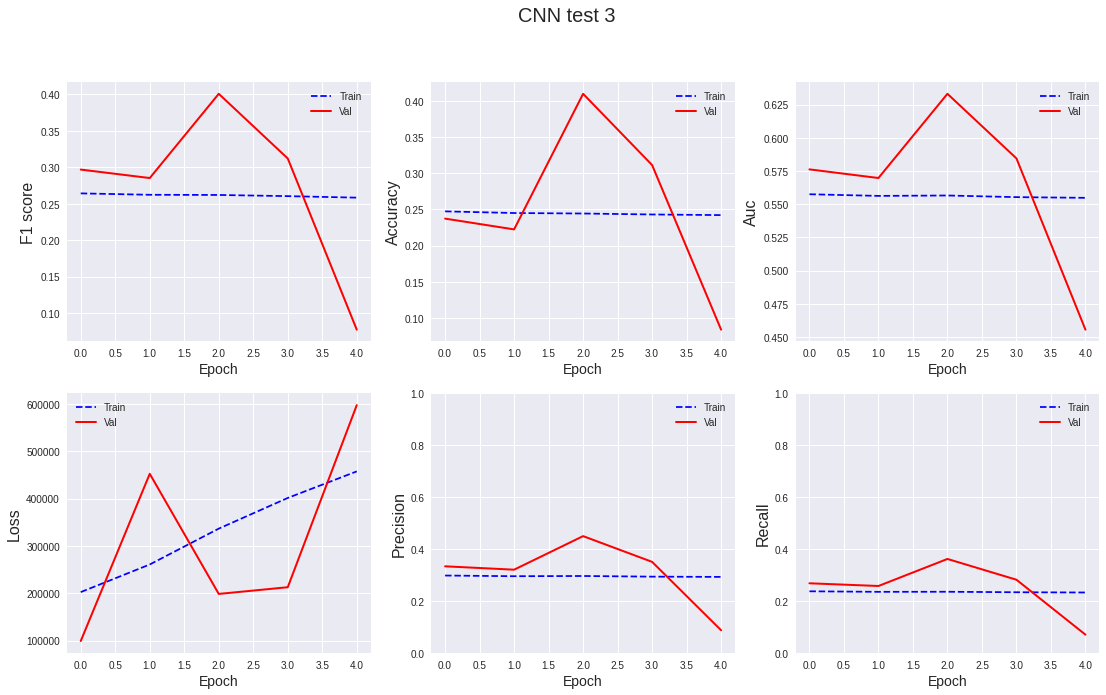

In [25]:
figName = "CNN test 3"

metrics =  ['f1_score', 'accuracy','auc', 'loss', 'precision', 'recall']
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,3,n+1)
    plt.plot(history.epoch,  history.history[metric], 'b', linestyle="--", label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], 'r', label='Val',linewidth=2.0)
    plt.xlabel('Epoch',fontsize = 14)
    plt.ylabel(name, fontsize = 16)
    if metric == 'precision' or metric == 'recall':
      plt.ylim([0.0,1])
    else:
        plt.ylim([plt.ylim()[0], plt.ylim()[1]])

    plt.legend()
fig.suptitle(figName,fontsize=20)
fig.savefig(figName+'.png')